## Module 3 Final Project Submission - Predicting Water Pump Functionality in Tanzania
* Student name: Emily J. Cain
* Student pace: Full Time
* Scheduled project review date/time: January 14, 2019
* Instructor name: Rafael Carrasco
* Blog post URL:

In [1]:
# Notes
# create functions / loops when necessary for DRY code
# consistent header sizes, viz colors
# Permit column? 
# TSH - need to standardize?
# possibly drop date_recorded unless it appears to have a correlation with pump status - indicating that repairs were
# made at that time
# Consider dropping wpt_name due to the largest value being unknown
# Figure out a way to fill unknown values for construction_year
# Probably drop payment type from the dataset because that should have no effect on well functionality unless
# there is some lurking variable at play that determines payment type
# Drop columns like subvillage and other categorical location features
# Scale continuous variables (RobustScaler if there are major outliers, StandardScaler if normal dist) - exclude
# binary columns from scaling
# populate 0 values where needed (TSH? GPS Height?)
# violin plots
# Change categorical columns to type category for one hot encoding or get_dummies

### Sources 
* DrivenData - Data Science Competitions with Social Impact
 * https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/
* Taarifa - an open source platform that helps citizens engage with their local government
 * http://taarifa.org/
* Tanzanian Ministry of Water
 * http://maji.go.tz/

### Targets for Water Pump Functionality
* Functioning
* Functioning, in need of repair
* Non-functioning

### Data Features
* amount_tsh - total static head - amount of water available to waterpoint
* date_recorded
* funder - who funded the well
* gps_height - altitude of the well
* installer - organization that installed the well
* longitude
* latitude
* wpt_name - name of waterpoint
* num_private
* basin 
* subvillage
* region
* region_code
* district_code
* lga - geographic location
* ward - geographic location
* population
* public_meeting
* recorded_by - group that collected the data for this well
* scheme_management - who operates the waterpoint
* scheme_name
* permit
* construction_year
* extraction_type
* extraction_type_group
* extraction_type_class
* management
* payment - what the water costs
* payment_type
* water_quality
* quality_group
* quantity
* quantity_group
* source - source of the water
* source_type
* source_class
* waterpoint_type
* waterpoint_type_group

In [2]:
import pandas as pd
import numpy as np
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### I. Load & Inspect the Data

In [3]:
feature_df = pd.read_csv('waterpumpfeatures.csv')
target_df = pd.read_csv('traintargets.csv')

In [4]:
feature_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
feature_df.shape

(59400, 40)

In [6]:
target_df.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [7]:
target_df.shape

(59400, 2)

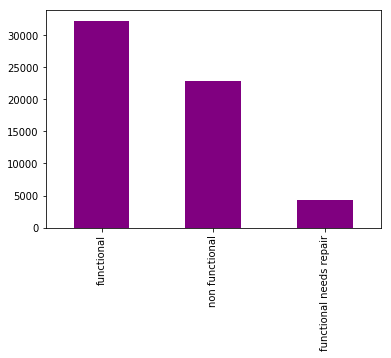

In [8]:
target_df.status_group.value_counts().plot(kind='bar', color='purple');

In [9]:
df = pd.merge(target_df, feature_df, left_index=True, right_index=True)
df.head()

,id_x,status_group,id_y,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### II. Data Cleaning & Exploratory Data Analysis

In [10]:
df.describe()

,id_x,id_y,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [11]:
df.dtypes

id_x                       int64
status_group              object
id_y                       int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management

#### Drop 'id' column

In [12]:
df.drop(['id_x', 'id_y'], axis=1, inplace=True)

In [13]:
df.head()

,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


#### Check for null and placeholder values

In [14]:
df.isnull().sum()

status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [15]:
df.status_group.unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

### Funder

In [16]:
df.funder.value_counts().nlargest(50)

Government Of Tanzania            9084
Danida                            3114
Hesawa                            2202
Rwssp                             1374
World Bank                        1349
Kkkt                              1287
World Vision                      1246
Unicef                            1057
Tasaf                              877
District Council                   843
Dhv                                829
Private Individual                 826
Dwsp                               811
0                                  777
Norad                              765
Germany Republi                    610
Tcrs                               602
Ministry Of Water                  590
Water                              583
Dwe                                484
Netherlands                        470
Hifab                              450
Adb                                448
Lga                                442
Amref                              425
Fini Water               

#### Replace null and '0' values in 'funder' column with 'Unknown'

In [17]:
df.funder.fillna('Unknown', inplace=True)

In [18]:
df.funder.replace({'0': 'Unknown'}, inplace=True)

In [19]:
df.funder.value_counts().nlargest(5)

Government Of Tanzania    9084
Unknown                   4416
Danida                    3114
Hesawa                    2202
Rwssp                     1374
Name: funder, dtype: int64

#### Drop 'funder' column from the dataset because this should not have a direct effect on functionality

In [20]:
df.drop('funder', axis=1, inplace=True)

### Installer

In [21]:
df.installer.value_counts().nlargest(50)

DWE                           17402
Government                     1825
RWE                            1206
Commu                          1060
DANIDA                         1050
KKKT                            898
Hesawa                          840
0                               777
TCRS                            707
Central government              622
CES                             610
Community                       553
DANID                           552
District Council                551
HESAWA                          539
LGA                             408
World vision                    408
WEDECO                          397
TASAF                           396
District council                392
Gover                           383
AMREF                           329
TWESA                           316
WU                              301
Dmdd                            287
ACRA                            278
World Vision                    270
SEMA                        

#### Replace null and '0' values in 'installer' column with 'Unknown'

In [22]:
df.installer.replace({'0': 'Unknown', np.nan: 'Unknown'}, inplace=True)

In [23]:
df.installer.value_counts().nlargest(5)

DWE           17402
Unknown        4435
Government     1825
RWE            1206
Commu          1060
Name: installer, dtype: int64

#### Drop 'installer' column from the dataset because this should not have an impact of well functionality

In [24]:
df.drop('installer', axis=1, inplace=True)

### Subvillage

In [25]:
df.subvillage.value_counts().nlargest(50)

Madukani                508
Shuleni                 506
Majengo                 502
Kati                    373
Mtakuja                 262
Sokoni                  232
M                       187
Muungano                172
Mbuyuni                 164
Mlimani                 152
Songambele              147
Miembeni                134
Msikitini               134
1                       132
Kibaoni                 114
Kanisani                111
Mapinduzi               109
I                       109
Mjimwema                108
Mjini                   108
Mkwajuni                104
Mwenge                  102
Azimio                   98
Mabatini                 98
Mission                  95
Mbugani                  95
Bwawani                  91
Bondeni                  90
Chang'Ombe               88
Zahanati                 86
Senta                    84
Kichangani               84
Mtaa Wa Kitunda Kati     84
Misufini                 83
Center                   82
Nyerere             

#### Replace null values with 'Unknown'

In [26]:
df.subvillage.fillna('Unknown', inplace=True)

In [27]:
df.subvillage.isnull().sum()

0

#### Drop 'subvillage' from the dataset because the name of the village should not affect well functionality and there are better columns to describe location - if location is an important feature

In [28]:
df.drop('subvillage', axis=1, inplace=True)

### Public Meeting

In [29]:
df.public_meeting.value_counts().nlargest(50)

True     51011
False     5055
Name: public_meeting, dtype: int64

#### Unclear at this time what the 'public_meeting' column represents, but will replace null values with the majority value of 'True' and change the boolean values to 0 and 1

In [30]:
df.public_meeting.replace({'True': 1, 'False': 0, np.nan: 1}, inplace=True)

In [31]:
df.public_meeting.value_counts()

True     54345
False     5055
Name: public_meeting, dtype: int64

In [32]:
df.public_meeting.head()

0    True
1       1
2    True
3    True
4    True
Name: public_meeting, dtype: object

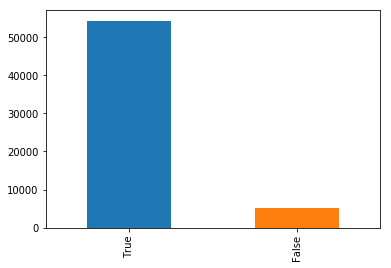

In [33]:
df.public_meeting.value_counts().plot(kind='bar');

### Scheme Management

In [34]:
df.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

#### Replace null, 'Other', and 'None' values to 'Unknown'

In [35]:
df.scheme_management.replace({'None': 'Unknown', np.nan: 'Unknown', 'Other': 'Unknown'}, inplace=True)

In [36]:
df.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Unknown              4644
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
SWC                    97
Trust                  72
Name: scheme_management, dtype: int64

#### Will drop 'scheme_management' from the dataset due to containing duplicate information

In [37]:
df.drop('scheme_management', axis=1, inplace=True)

### Scheme Name

In [38]:
df.scheme_name.value_counts().nlargest(50)

K                                        682
None                                     644
Borehole                                 546
Chalinze wate                            405
M                                        400
DANIDA                                   379
Government                               320
Ngana water supplied scheme              270
wanging'ombe water supply s              261
wanging'ombe supply scheme               234
I                                        229
Bagamoyo wate                            229
Uroki-Bomang'ombe water sup              209
N                                        204
Kirua kahe gravity water supply trust    193
Machumba estate pipe line                185
Makwale water supplied sche              166
Kijiji                                   161
S                                        154
Losaa-Kia water supply                   152
mtwango water supply scheme              152
Handeni Trunk Main(H                     152
Mkongoro T

#### Replace null and 'None' values to 'Unknown'

In [39]:
df.scheme_name.replace({np.nan: 'Unknown', 'None': 'Unknown'}, inplace=True)

In [40]:
df.scheme_name.value_counts().nlargest(5)

Unknown          28810
K                  682
Borehole           546
Chalinze wate      405
M                  400
Name: scheme_name, dtype: int64

#### Drop 'scheme_name' from the dataset because the majority of values are unknown, and there could be duplicate values from 'scheme_management'

In [41]:
df.drop('scheme_name', axis=1, inplace=True)

### Permit

In [42]:
df.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

#### Change null values to 'Unknown' at this time

In [43]:
df.permit.fillna('Unknown', inplace=True)

In [44]:
df.isnull().sum()

status_group             0
amount_tsh               0
date_recorded            0
gps_height               0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
dtype: int64

### Amount TSH (Total static head)

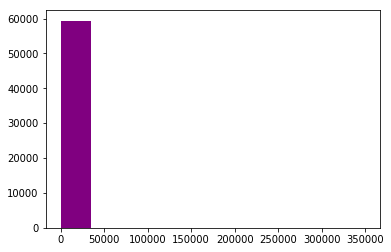

In [45]:
plt.hist(df.amount_tsh, color='purple');

In [46]:
df.amount_tsh.value_counts().nlargest(50)

0.0        41639
500.0       3102
50.0        2472
1000.0      1488
20.0        1463
200.0       1220
100.0        816
10.0         806
30.0         743
2000.0       704
250.0        569
300.0        557
5000.0       450
5.0          376
25.0         356
3000.0       334
1200.0       267
1500.0       197
6.0          190
600.0        176
4000.0       156
2400.0       145
2500.0       139
6000.0       125
7.0           69
8000.0        61
750.0         59
40.0          59
10000.0       57
12000.0       51
20000.0       45
3600.0        42
400.0         42
450.0         42
2200.0        31
700.0         24
4700.0        23
70.0          23
150.0         21
33.0          20
15000.0       16
60.0          15
15.0          15
2800.0        14
2.0           13
7200.0        12
1300.0        10
6500.0         9
25000.0        9
30000.0        8
Name: amount_tsh, dtype: int64

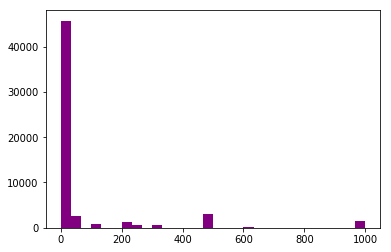

In [47]:
plt.hist(df.amount_tsh, color='purple', range=(0,1000), bins=30);

In [48]:
df.amount_tsh.mean()

317.6503846801347

### Date Recorded

In [49]:
date_df = df[['date_recorded', 'construction_year']]

In [50]:
date_df.head(15)

,date_recorded,construction_year
0,2011-03-14,1999
1,2013-03-06,2010
2,2013-02-25,2009
3,2013-01-28,1986
4,2011-07-13,0
5,2011-03-13,2009
6,2012-10-01,0
7,2012-10-09,0
8,2012-11-03,0
9,2011-08-03,0


In [51]:
date_df.tail(15)

,date_recorded,construction_year
59385,2012-11-03,2011
59386,2011-08-22,2009
59387,2013-03-12,2000
59388,2013-01-29,1995
59389,2011-08-06,2009
59390,2011-08-04,1991
59391,2013-08-03,1967
59392,2011-04-15,0
59393,2012-10-27,0
59394,2011-03-09,2007


#### The 'date_recorded' years are different from the 'construction_year' column, so this information should not have an impact on well functionality unless repairs were also made on these dates - which is not known. 

In [52]:
df.drop('date_recorded', axis=1, inplace=True)

### GPS Height

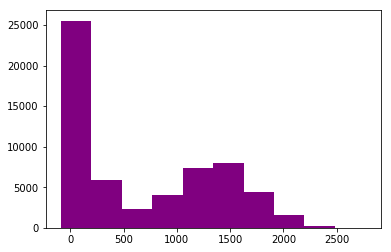

In [53]:
plt.hist(df.gps_height, color='purple');

### Longitude

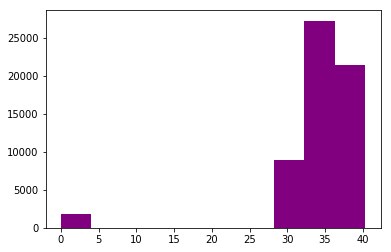

In [54]:
plt.hist(df.longitude, color='purple');

In [55]:
df.longitude.value_counts()

0.000000     1812
37.540901       2
33.010510       2
39.093484       2
32.972719       2
33.006275       2
39.103950       2
37.542785       2
36.802490       2
39.098374       2
33.090347       2
33.005032       2
32.978062       2
39.088875       2
31.619530       2
39.093095       2
39.105307       2
32.936689       2
32.987511       2
39.090880       2
37.314250       2
32.984790       2
39.091434       2
37.274352       2
32.919861       2
37.530515       2
32.955597       2
39.098514       2
32.988560       2
32.987670       2
             ... 
36.831815       1
31.530352       1
35.455622       1
37.672581       1
29.964104       1
34.862237       1
37.663466       1
37.128824       1
38.766058       1
38.710520       1
40.117029       1
34.672962       1
39.433604       1
35.901580       1
37.532216       1
35.790038       1
33.926958       1
37.371204       1
33.494134       1
34.462228       1
36.658880       1
33.877577       1
38.579468       1
31.715232       1
36.871976 

#### Replace missing values with the mean longitude

In [56]:
mean_long = round(df.longitude.mean(), 6)
mean_long

34.077427

In [57]:
df.longitude.replace({0.000000: mean_long}, inplace=True)

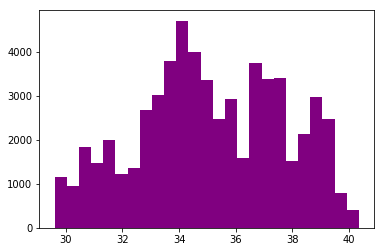

In [58]:
plt.hist(df.longitude, color='purple', bins=25);

### Latitude

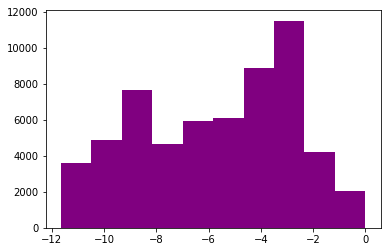

In [59]:
plt.hist(df.latitude, color='purple');

### Wpt name

In [60]:
df.wpt_name.value_counts().nlargest(50)

none                 3563
Shuleni              1748
Zahanati              830
Msikitini             535
Kanisani              323
Bombani               271
Sokoni                260
Ofisini               254
School                208
Shule Ya Msingi       199
Shule                 152
Sekondari             146
Muungano              133
Mkombozi              111
Madukani              104
Mbugani                94
Hospital               94
Upendo                 93
Kituo Cha Afya         90
Mkuyuni                88
Umoja                  84
Center                 83
Ccm                    81
Kisimani               78
Mtakuja                76
Ofisi Ya Kijiji        76
Tankini                73
Songambele             66
Bwawani                66
Maendeleo              64
Bondeni                61
Mbuyuni                59
Uwanjani               57
Kilabuni               55
Mnadani                52
Kijiweni               51
Secondary              49
Miembeni               49
Amani       

#### Change 'none' to 'Unknown'

In [61]:
df.wpt_name.replace({'none': 'Unknown'}, inplace=True)

In [62]:
df.wpt_name.value_counts().nlargest(5)

Unknown      3566
Shuleni      1748
Zahanati      830
Msikitini     535
Kanisani      323
Name: wpt_name, dtype: int64

#### Drop 'wpt_name' from the dataset because the name should not have an effect on well functionality

In [63]:
df.drop('wpt_name', axis=1, inplace=True)

### Num private

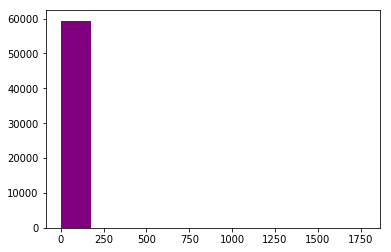

In [64]:
plt.hist(df.num_private, color='purple');

In [65]:
df.num_private.value_counts().nlargest(15)

0     58643
6        81
1        73
5        46
8        46
32       40
45       36
15       35
39       30
93       28
3        27
7        26
2        23
65       22
47       21
Name: num_private, dtype: int64

#### Unclear as to what this column represents with a majority of zero values, so will drop it from the dataset

In [66]:
df.drop('num_private', axis=1, inplace=True)

In [67]:
df.columns

Index(['status_group', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'basin', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

### Basin

In [68]:
df.basin.value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

### Region

In [69]:
df.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [70]:
len(df.region.value_counts())

21

#### Will drop the 'region' column from the dataset to avoid duplicating information

In [71]:
df.drop('region', axis=1, inplace=True)

### Region code

In [72]:
df.region_code.value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [73]:
len(df.region_code.value_counts())

27

#### Will drop 'region_code' from the dataset because 'latitude' and 'longitude' will be used for location features

In [74]:
df.drop('region_code', axis=1, inplace=True)

### District code

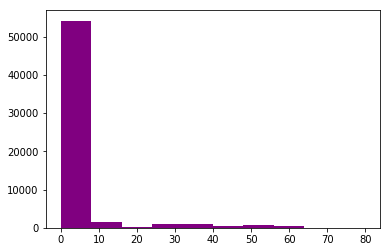

In [75]:
plt.hist(df.district_code, color='purple');

In [76]:
df.district_code.value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

In [77]:
len(df.district_code.value_counts())

20

#### Will drop 'district_code' from the dataset because 'latitude' and 'longitude' will be used as location features

In [78]:
df.drop('district_code', axis=1, inplace=True)

### LGA

In [79]:
df.lga.value_counts()

Njombe              2503
Arusha Rural        1252
Moshi Rural         1251
Bariadi             1177
Rungwe              1106
Kilosa              1094
Kasulu              1047
Mbozi               1034
Meru                1009
Bagamoyo             997
Singida Rural        995
Kilombero            959
Same                 877
Kibondo              874
Kyela                859
Kahama               836
Magu                 824
Kigoma Rural         824
Maswa                809
Karagwe              771
Mbinga               750
Iringa Rural         728
Serengeti            716
Namtumbo             694
Lushoto              694
Songea Rural         693
Mpanda               679
Mvomero              671
Ngara                669
Ulanga               665
                    ... 
Newala               231
Bahi                 224
Kisarawe             223
Temeke               215
Rorya                210
Tarime               209
Ngorongoro           201
Kiteto               193
Shinyanga Urban      191


#### Will drop 'lga' from the dataset because there are more concise location columns

In [80]:
df.drop('lga', axis=1, inplace=True)

### Ward

In [81]:
df.ward.value_counts()

Igosi               307
Imalinyi            252
Siha Kati           232
Mdandu              231
Nduruma             217
Kitunda             203
Mishamo             203
Msindo              201
Chalinze            196
Maji ya Chai        190
Usuka               187
Ngarenanyuki        172
Chanika             171
Vikindu             162
Mtwango             153
Matola              145
Zinga/Ikerege       141
Maramba             139
Wanging'ombe        139
Itete               137
Magomeni            135
Ifakara             134
Kikatiti            134
Olkokola            133
Maposeni            130
Igongolo            129
Mvomero             129
Mlangali            125
Nkoma               122
Mahongole           121
                   ... 
Ikweha                1
Sungwisi              1
Chinugulu             1
Kinungu               1
Thawi                 1
Ukata                 1
Kirongo               1
Burungura             1
Kitete                1
Igogo                 1
Korongoni       

#### Will drop 'ward' from the dataset because there are more concise location columns

In [82]:
df.drop('ward', axis=1, inplace=True)

### Population

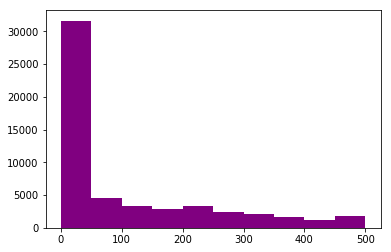

In [83]:
plt.hist(df.population, color='purple', range=(0,500));

### Recorded by

In [84]:
df.recorded_by.value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

#### Will drop the 'recorded_by' column from the dataset since all values are the same

In [85]:
df.drop('recorded_by', axis=1, inplace=True)

### Construction year

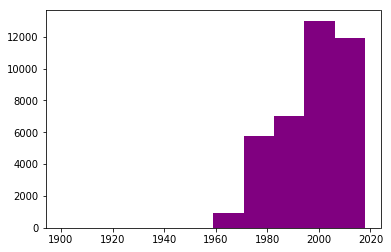

In [86]:
plt.hist(df.construction_year, color='purple', range=(1900,2018));

In [87]:
df.construction_year.value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [88]:
df.construction_year.median()

1986.0

#### Check for shared properties between wells built in the same year as a possible way to populate missing values

In [89]:
# df.loc[df.construction_year == 1986]

In [90]:
# df.loc[df.construction_year == 2000]

In [91]:
# df.loc[df.construction_year == 1970]

#### There are no obvious shared properties between wells built in the same year, so populating these missing values could negatively affect the model. The fact that the year is missing could be relevant (i.e. missing years might indicate an older well).

In [92]:
# df.construction_year.replace({0: 'Unknown'}, inplace=True)

### Extraction type

In [93]:
df.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

#### Drop 'extraction_type' column from the dataset due to containing brand names of pumps and duplicating information

In [94]:
df.drop('extraction_type', axis=1, inplace=True)

### Extraction type group

In [95]:
df.extraction_type_group.value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

#### Drop 'extraction_type_group' column from the dataset due to containing brand names of pumps and duplicating information

In [96]:
df.drop('extraction_type_group', axis=1, inplace=True)

### Extraction type class

In [97]:
df.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

### Management

In [98]:
df.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

#### Consolidate 'other' values with 'unknown' and change 'other - school' to 'school' for clarity

In [99]:
df.management.replace({'other': 'unknown', 'other - school': 'school'}, inplace=True)

In [100]:
df.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
unknown              1405
water authority       904
company               685
school                 99
trust                  78
Name: management, dtype: int64

### Management group

In [101]:
df.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

#### Drop 'management_group' column from the dataset due to containing duplicate but less informative values

In [102]:
df.drop('management_group', axis=1, inplace=True)

### Payment

In [103]:
df.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

#### Drop 'payment' column from the dataset due to containing duplicate information

In [104]:
df.drop('payment', axis=1, inplace=True)

### Payment type

In [105]:
df.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

#### Consolidate 'other' with 'unknown' values

In [106]:
df.payment_type.replace({'other': 'unknown'}, inplace=True)

In [107]:
df.payment_type.value_counts()

never pay     25348
unknown        9211
per bucket     8985
monthly        8300
on failure     3914
annually       3642
Name: payment_type, dtype: int64

### Water Quality

In [108]:
df.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

#### Drop 'water_quality' column from the dataset due to containing duplicate, less-concise information than 'quality_group'

In [109]:
df.drop('water_quality', axis=1, inplace=True)

### Quality Group

In [110]:
df.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

### Quantity

In [111]:
df.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

### Quantity Group

In [112]:
df.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

#### Drop 'quantity_group' column from dataset due to containing duplicate information

In [113]:
df.drop('quantity_group', axis=1, inplace=True)

### Source

In [114]:
df.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

#### Drop 'source' column from the dataset due to containing duplicate information

In [115]:
df.drop('source', axis=1, inplace=True)

### Source Type

In [116]:
df.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

### Source Class

In [117]:
df.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

#### Drop 'source_class' column due to containing duplicate, less-informative values than the 'source_type' column

In [118]:
df.drop('source_class', axis=1, inplace=True)

### Waterpoint Type

In [119]:
df.waterpoint_type.value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

#### Drop 'waterpoint_type' column due to containing duplicate information

In [120]:
df.drop('waterpoint_type', axis=1, inplace=True)

### Waterpoint Type Group

In [121]:
df.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [122]:
df.head()

,status_group,amount_tsh,gps_height,longitude,latitude,basin,population,public_meeting,permit,construction_year,extraction_type_class,management,payment_type,quality_group,quantity,source_type,waterpoint_type_group
0,functional,6000.0,1390,34.938093,-9.856322,Lake Nyasa,109,True,False,1999,gravity,vwc,annually,good,enough,spring,communal standpipe
1,functional,0.0,1399,34.698766,-2.147466,Lake Victoria,280,1,True,2010,gravity,wug,never pay,good,insufficient,rainwater harvesting,communal standpipe
2,functional,25.0,686,37.460664,-3.821329,Pangani,250,True,True,2009,gravity,vwc,per bucket,good,enough,dam,communal standpipe
3,non functional,0.0,263,38.486161,-11.155298,Ruvuma / Southern Coast,58,True,True,1986,submersible,vwc,never pay,good,dry,borehole,communal standpipe
4,functional,0.0,0,31.130847,-1.825359,Lake Victoria,0,True,True,0,gravity,unknown,never pay,good,seasonal,rainwater harvesting,communal standpipe


In [123]:
df.dtypes

status_group              object
amount_tsh               float64
gps_height                 int64
longitude                float64
latitude                 float64
basin                     object
population                 int64
public_meeting            object
permit                    object
construction_year          int64
extraction_type_class     object
management                object
payment_type              object
quality_group             object
quantity                  object
source_type               object
waterpoint_type_group     object
dtype: object

#### Change type for boolean columns

In [124]:
df.public_meeting = df.public_meeting.astype('bool')
df.permit = df.permit.astype('bool')

In [125]:
df.dtypes

status_group              object
amount_tsh               float64
gps_height                 int64
longitude                float64
latitude                 float64
basin                     object
population                 int64
public_meeting              bool
permit                      bool
construction_year          int64
extraction_type_class     object
management                object
payment_type              object
quality_group             object
quantity                  object
source_type               object
waterpoint_type_group     object
dtype: object

#### Split the dataframe into target and feature variables

In [126]:
y = df.status_group

In [127]:
y.head()

0        functional
1        functional
2        functional
3    non functional
4        functional
Name: status_group, dtype: object

In [129]:
X = df.drop('status_group', axis=1)

In [130]:
X.head()

,amount_tsh,gps_height,longitude,latitude,basin,population,public_meeting,permit,construction_year,extraction_type_class,management,payment_type,quality_group,quantity,source_type,waterpoint_type_group
0,6000.0,1390,34.938093,-9.856322,Lake Nyasa,109,True,False,1999,gravity,vwc,annually,good,enough,spring,communal standpipe
1,0.0,1399,34.698766,-2.147466,Lake Victoria,280,True,True,2010,gravity,wug,never pay,good,insufficient,rainwater harvesting,communal standpipe
2,25.0,686,37.460664,-3.821329,Pangani,250,True,True,2009,gravity,vwc,per bucket,good,enough,dam,communal standpipe
3,0.0,263,38.486161,-11.155298,Ruvuma / Southern Coast,58,True,True,1986,submersible,vwc,never pay,good,dry,borehole,communal standpipe
4,0.0,0,31.130847,-1.825359,Lake Victoria,0,True,True,0,gravity,unknown,never pay,good,seasonal,rainwater harvesting,communal standpipe
